# Scope Measurement Data Analysis 
This notebook has data analysis for a high speed oscilloscope measurement of three tones generated by the ZVA67. The tones on channel 3 and 4 are generated by port 3 and are phase shifted from each other. The original tone from port 3 is split and divided by a large number to provide the trigger pulse. Channel 2 of the oscilloscope measures another tone from port 1. The tone from port 1 is swept along a small frequency grid which should be harmonically related to the trigger signal.

## Questions to be answered
1. What is the phase stability of channels 3 and 4 before and after time base correction
2. Is the phase of channel 2 for different frequencies before and after time-base correction
3. Can we extract an equivalent receiver value from the measurement of the tones
4. Does the phase of this equivalent receiver value have a constant relationship to the phase of the ZVA receiver value
5. Can we transfer the power calibration of the ZVA to the oscilloscope, or does the amplitude of ratio of the receiver value stay constant
6. Can we read the wave parameter values for port 1 while we step the frequency
7. Can we measure port 1 given the trigger signal generated from port 3
8. Can we use this phase calibration on the ZVA to measure a communications signal (11-12 tones with known phase relationship)
9. What are the pitfalls in acquisition? If certain data is corrupt why?
    + The trace names on the ZVA changed when I did the sparameter cal make sure these are constant
    + The frequency of the port 1 signal is not what I expected, it changed to fb*offset 
    + The frequency grid for port 1 is not harmonically related to the trigger frequency
    + The frequency grid of the VNA sparameter cal and power cal was the anticipated frequency and not the actual frequency
    + The first point of Channel 1 sometimes has a 1 in front of it 
    + TBC requires data with no header and that is tab delimited


In [3]:
# data directories
initial_measurements=r"C:\Share\LongDurationLSNA\20180201_Scope_Measurements" 
# No schemas and no VNA data just a check to see if it works

phase_cal_2=r"C:\Share\LongDurationLSNA\20180202_Phase_Cal_2"
# There was a naming error that caused either an overwrite of data or loss of data 19 measurements instead of 21

phase_cal_3=r"C:\Share\LongDurationLSNA\20180205_Phase_Cal_3"
# this is after the naming error was fixed, but the vna data is corrupt

phase_cal_4=r"C:\Share\LongDurationLSNA\20180205_Phase_Cal_4"
# The frequency set for port1 is different than expected, but the vna data is good

statisitics_phase_1=r"C:\Share\LongDurationLSNA\20180205_Statistics_Phase"
# Repeats with all of the tones at the same frequency, vna data maybe corrupt (due to renaming the traces)

statisitics_phase_2=r"C:\Share\LongDurationLSNA\20180205_Statistics_Phase_2"
# Repeats with all of the tones at the same frequency, vna data maybe corrupt (due to renaming the traces)

first_full_measurement=r"C:\Share\LongDurationLSNA\20180202_Trigger_Measurements"
# includes power and sparameter calibration files, but does not have all the frequency points

tbc_different_frequency=r"C:\Share\LongDurationLSNA\20180205_Different_Frequencies_TBC"
# a data set with all the tones set to the location of the trigger base frequency data is for tbc  2.037 ghz

tbc_different_frequency_2=r"C:\Share\LongDurationLSNA\20180205_Different_Frequencies_TBC_2"
# two scope sets of data for different tones at 3Ghz and 1.337 GHz

tbc_different_frequency=r"C:\Share\LongDurationLSNA\20180205_Different_Frequencies_TBC_3"
# scope data at 3.7GHz and 2.111 GHZ with full calibration data 

long_time_data=r"C:\Share\LongDurationLSNA\20180202_Trigger_Measurements"
# The first phase call with some multiframe data from the oscilloscope

large_frequency_sweep=r"C:\Share\LongDurationLSNA\20180205_Very_Long_Phase Cal"
# lots of points in the sweep grid for port 1, vna may be messed up

In [2]:
# load needed modules
from pyMez import *
from pyMez.Code.Analysis.Fitting import *

Importing pyMez, this should take roughly 30 seconds
Importing Code.DataHandlers.GeneralModels
It took 4.494 s to import Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.HTMLModels
It took 0.889 s to import Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.NISTModels
It took 14.268 s to import Code.DataHandlers.NISTModels
Importing Code.DataHandlers.TouchstoneModels
It took 0.018 s to import Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
It took 0.668 s to import Code.DataHandlers.XMLModels
Importing Code.DataHandlers.ZipModels
It took 0.046 s to import Code.DataHandlers.ZipModels
Importing Code.InstrumentControl.Experiments
It took 2.753 s to import Code.InstrumentControl.Experiments
Importing Code.InstrumentControl.Instruments
It took 0.029 s to import Code.InstrumentControl.Instruments
Importing Code.Utils.Names
It took 0.024 s to import Code.Utils.Names
It took 23.189 s to import all of the active modules


In [87]:
# Now to fit all the data for I and Q (the signals on channel 3 and 4 of the oscope)
directories=[phase_cal_2,phase_cal_3,phase_cal_4,
             statisitics_phase_1,statisitics_phase_2,
             large_frequency_sweep]
# Each of these directories has data for the port 3 frequency (Channels 3 and 4) set to 2.048 ghz
start_stop_list=[{"start":2,"stop":19},{"start":1,"stop":21},{"start":1,"stop":21},
               {"start":1,"stop":21},{"start":1,"stop":21},
               {"start":1,"stop":402}]
base_names=["Scan_SUT_Test_Highspeed_Oscilloscope_20180202_{0:03d}.dat",
            "Scan_SUT_Test_Highspeed_Oscilloscope_20180205_{0:03d}.dat",
            "Scan_SUT_Test_Highspeed_Oscilloscope_20180205_{0:03d}.dat",
            "Scan_SUT_Test_Highspeed_Oscilloscope_20180205_{0:03d}.dat",
            "Scan_SUT_Test_Highspeed_Oscilloscope_20180205_{0:03d}.dat",
            "Scan_SUT_Test_Highspeed_Oscilloscope_20180205_{0:03d}.dat"]
# This controls tScan_SUT_Test_Highspeed_Oscilloscope_20180202_002.date number of files that gets imported and their names
def remove_bad_data_point(file_path):
    """ This removes any data point that has a 1- in front of it"""
    in_file=open(file_path,"r")
    content=in_file.read()
    content=content.replace("1-","-")
    in_file.close()
    out_file=open(file_path,"w")
    out_file.write(content)
    out_file.close()

In [88]:
# build file_name list
all_file_names=[]
fit_by_session=[]
all_fits=[]
data_table_list=[]
fit_table_list=[]
f_base=2.048
for directory_index,directory in enumerate(directories[:]):
    loop_i=start_stop_list[directory_index]["start"]
    fit_row=[]
    fit_data_row=[]
    data_table_row=[]
    while (loop_i<=start_stop_list[directory_index]["stop"]):
        print("{0} is {1}".format("loop_i",loop_i))
        file_path=os.path.join(directory,base_names[directory_index].format(loop_i))
        all_file_names.append(file_path)
        remove_bad_data_point(file_path)
        schema=read_schema(change_extension(file_path,new_extension="schema"))
        schema["column_types"]=["float" for i in range(5)]
        scope_measurement=AsciiDataTable(file_path,**schema)
        data_table_row.append(scope_measurement)
        I_fit=FunctionalModel(equation="a*sin(2.*3.1415*{0}*x+phi)".format(f_base),variables="x",parameters="phi a")
        Q_fit=FunctionalModel(equation="a*sin(2.*3.1415*{0}*x+phi)".format(f_base),variables="x",parameters="phi a")
        n_points=len(scope_measurement.data)
        time_base=[10./n_points*.1*float(i) for i in range(n_points)]
        I_fit.fit_data(time_base,scope_measurement["CHAN3"])
        Q_fit.fit_data(time_base,scope_measurement["CHAN4"])
        fit_row.append([I_fit,Q_fit])
        fit_data_row.append(map(lambda x:x.parameter_values,[I_fit,Q_fit]))
        loop_i+=1
        print("{0} is {1}".format("loop_i",loop_i))
        print("{0} is {1}".format("truth condition",(i<=start_stop_list[directory_index]["stop"])))
    data_table_list.append(data_table_row)
    fit_table_list.append(fit_row)
    all_fits.append(fit_data_row)
        



loop_i is 2
The index variable is 0
The element variable is header
The import_table variable is [[0, None, None, None], [0, 1, None, None], [1, None, None, None]]
The index variable is 1
The element variable is column_names
The import_table variable is [[0, None, None, None], [0, 1, None, None], [1, None, None, None]]
The index variable is 2
The element variable is data
The import_table variable is [[0, None, None, None], [0, 1, None, None], [1, None, None, None]]
The index variable is 0
The element variable is header
The import_table variable is [[0, 0, None, None], [0, 1, None, None], [1, None, None, None]]
The index variable is 1
The element variable is column_names
The import_table variable is [[0, 0, None, None], [0, 1, None, None], [1, None, None, None]]
The index variable is 2
The element variable is data
The import_table variable is [[0, 0, None, None], [0, 1, None, None], [1, None, None, None]]
The index variable is 0
The element variable is header
The import_table variable is

IOError: [Errno 2] No such file or directory: 'C:\\Share\\LongDurationLSNA\\20180202_Trigger_Measurements\\Scan_SUT_Test_Highspeed_Oscilloscope_20180202_002.schema'

In [47]:
all_I_amplitudes=[all_fits[i][j][0]["a"]   for i in range(len(all_fits)) for j in range(len(all_fits[i]))]
all_Q_amplitudes=[all_fits[i][j][1]["a"]   for i in range(len(all_fits)) for j in range(len(all_fits[i]))]
all_I_phases=[all_fits[i][j][0]["phi"]   for i in range(len(all_fits)) for j in range(len(all_fits[i]))]
all_Q_phases=[all_fits[i][j][1]["phi"]   for i in range(len(all_fits)) for j in range(len(all_fits[i]))]
print("-"*80)
print("Amplitude Results")
print("The mean of all {0} |I| fits is {1} ".format(len(all_I_amplitudes),np.mean(all_I_amplitudes)))
print("The std of all {0} |I| fits is {1} ".format(len(all_I_amplitudes),np.std(all_I_amplitudes)))
print("The mean of all {0} |Q| fits is {1} ".format(len(all_Q_amplitudes),np.mean(all_Q_amplitudes)))
print("The std of all {0} |Q| fits is {1} ".format(len(all_Q_amplitudes),np.std(all_Q_amplitudes)))
print("The fractional uncertainty in |I| is {0} and in |Q| is {1}".format(np.std(all_I_amplitudes)/np.mean(all_I_amplitudes),
                                                                         np.std(all_Q_amplitudes)/np.mean(all_Q_amplitudes)))
print("-"*80)
print("Phase Results")
print("The mean of all {0} phase(I) fits is {1} ".format(len(all_I_phases),np.mean(all_I_phases)))
print("The std of all {0} phase(I) fits is {1} ".format(len(all_I_phases),np.std(all_I_phases)))
print("The mean of all {0} phase(Q) fits is {1} ".format(len(all_Q_phases),np.mean(all_Q_phases)))
print("The std of all {0} phase(Q) fits is {1} ".format(len(all_Q_phases),np.std(all_Q_phases)))
print("The nominal phase uncertainty in I is {0} degrees and in Q is {1} degrees".format(np.std(all_I_phases)*180/np.pi,
                                                                                         np.std(all_Q_phases)*180/np.pi))

--------------------------------------------------------------------------------
Amplitude Results
The mean of all 504 |I| fits is 0.0263021030721 
The std of all 504 |I| fits is 0.000140913284092 
The mean of all 504 |Q| fits is -0.0499370332482 
The std of all 504 |Q| fits is 0.000263204916079 
The fractional uncertainty in |I| is 0.00535749113693 and in |Q| is -0.00527073594402
--------------------------------------------------------------------------------
Phase Results
The mean of all 504 phase(I) fits is -0.126923138196 
The std of all 504 phase(I) fits is 0.0210260505394 
The mean of all 504 phase(Q) fits is 1.40011962886 
The std of all 504 phase(Q) fits is 0.0208162230616 
The nominal phase uncertainty in I is 1.20470395574 degrees and in Q is 1.19268172683 degrees


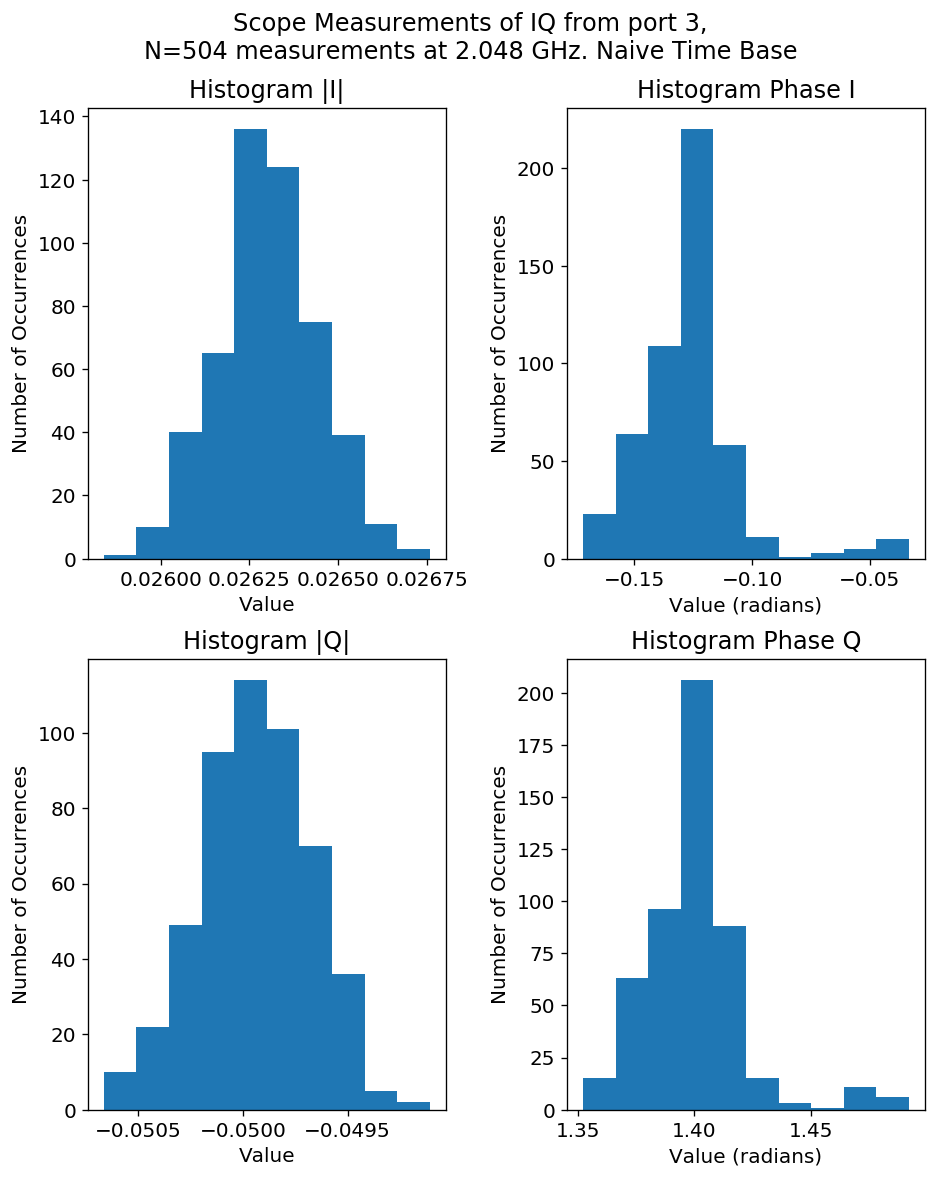

In [71]:
plt.close()
fig, plot_axes = plt.subplots(nrows=2, ncols=2,
                                   figsize=(8,10),
                                   dpi=120)
axes=plot_axes.flat
plt.rcParams.update({'font.size': 12})
axes[0].hist(all_I_amplitudes)
axes[0].set_title("Histogram |I|")
axes[0].set_ylabel("Number of Occurrences")
axes[0].set_xlabel("Value")
axes[0].ticklabel_format(style="sci")
axes[1].hist(all_I_phases)
axes[1].set_title("Histogram Phase I")
axes[1].set_ylabel("Number of Occurrences")
axes[1].set_xlabel("Value (radians)")
axes[1].ticklabel_format(style="sci")
axes[2].hist(all_Q_amplitudes)
axes[2].set_title("Histogram |Q|")
axes[2].set_ylabel("Number of Occurrences")
axes[2].set_xlabel("Value")
axes[2].ticklabel_format(style="sci")
axes[3].hist(all_Q_phases)
axes[3].set_title("Histogram Phase Q")
axes[3].set_ylabel("Number of Occurrences")
axes[3].set_xlabel("Value (radians)")
axes[3].ticklabel_format(style="sci")

fig.suptitle("""Scope Measurements of IQ from port 3,
N={0} measurements at 2.048 GHz. Naive Time Base""".format(len(all_I_amplitudes)))
plt.rcParams.update({'font.size': 12})
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [30]:
all_fits[0][0][0]["a"]

0.02616400836119842

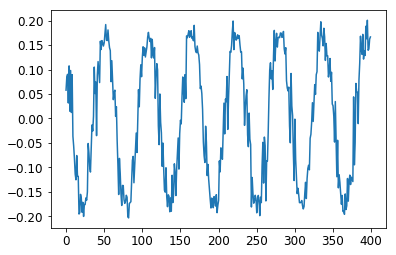

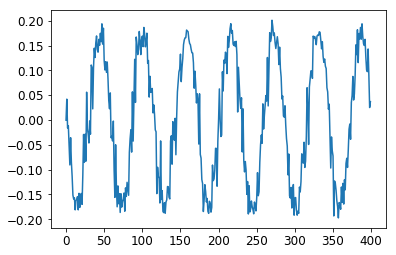

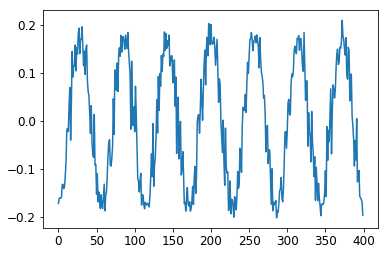

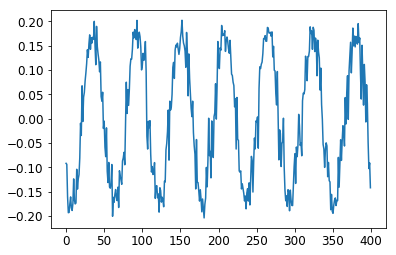

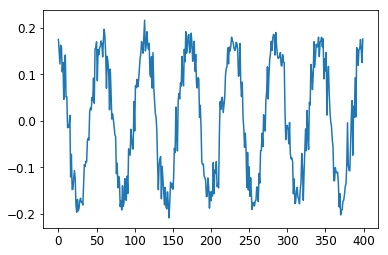

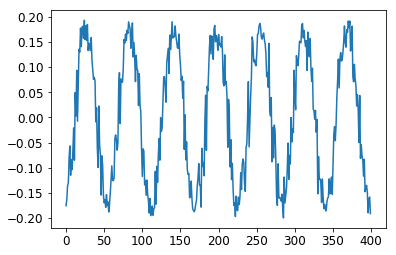

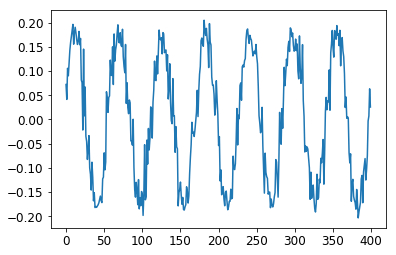

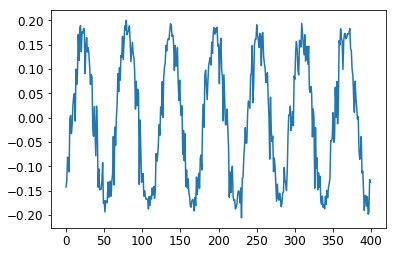

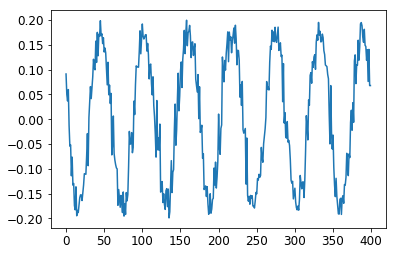

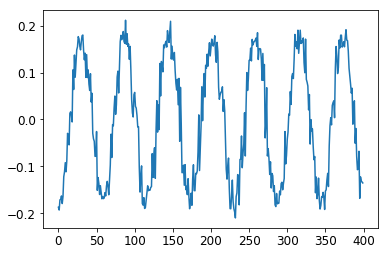

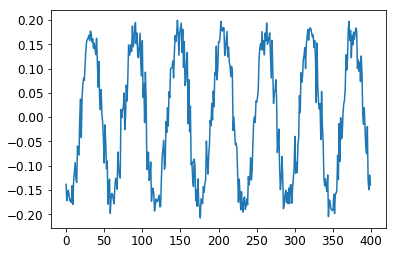

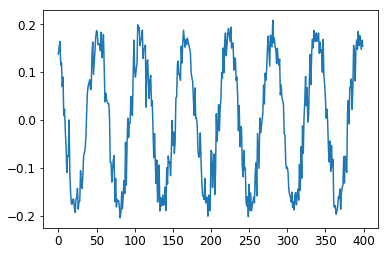

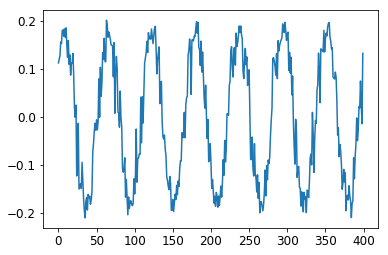

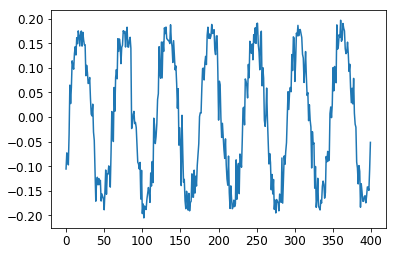

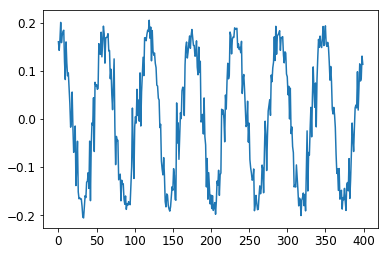

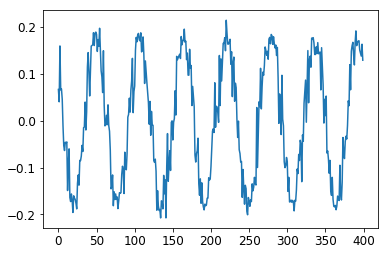

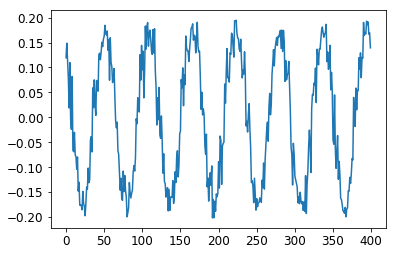

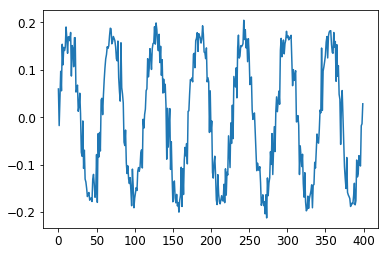

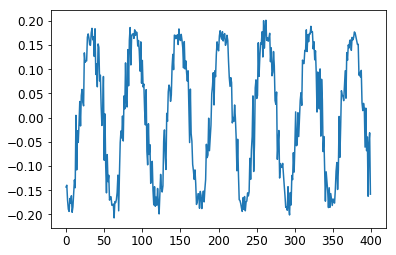

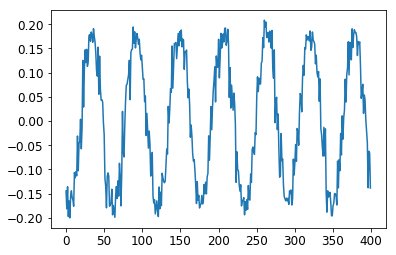

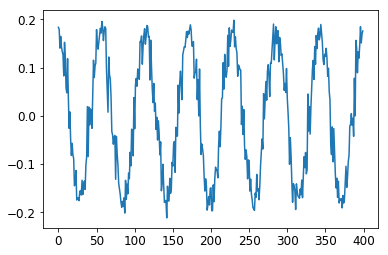

In [86]:
plt.close()
for data_table in data_table_list[-3][:]:
    plt.close()
    plt.plot(data_table["CHAN2"])
    plt.show()

In [93]:
remove_bad_data_point(r"C:\Share\LongDurationLSNA\20180201_Scope_Measurements\Scope_Measurement_20180201_002.dat")
trigger_run=AsciiDataTable(r"C:\Share\LongDurationLSNA\20180201_Scope_Measurements\Scope_Measurement_20180201_002.dat",
                          **schema)

The index variable is 0
The element variable is header
The import_table variable is [[0, None, None, None], [0, 1, None, None], [1, None, None, None]]
The index variable is 1
The element variable is column_names
The import_table variable is [[0, None, None, None], [0, 1, None, None], [1, None, None, None]]
The index variable is 2
The element variable is data
The import_table variable is [[0, None, None, None], [0, 1, None, None], [1, None, None, None]]
The index variable is 0
The element variable is header
The import_table variable is [[0, 0, None, None], [0, 1, None, None], [1, None, None, None]]
The index variable is 1
The element variable is column_names
The import_table variable is [[0, 0, None, None], [0, 1, None, None], [1, None, None, None]]
The index variable is 2
The element variable is data
The import_table variable is [[0, 0, None, None], [0, 1, None, None], [1, None, None, None]]
The index variable is 0
The element variable is header
The import_table variable is [[0, 0, Non

TypeConversionError: Convert row could not convert ['#omega = 207.196022717'] using ['float', 'float', 'float', 'float', 'float']

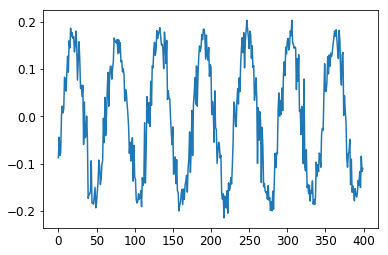

In [92]:
plt.plot(trigger_run["CHAN2"])
plt.show()